In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import random

In [4]:
import cv2

In [5]:
np.random.seed(0)

In [6]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


# 1.MNIST Data load
mnist 데이터는 28*28 사이즈를 가지며, 채널은 1개인 오픈 데이터셋입니다.

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 7s 1us/step


In [8]:
print ('x_train shape:',x_train.shape)
print ('x_test shape:',x_test.shape)
print ('y_train shape:',y_train.shape)
print ('y_test shape:',y_test.shape)

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)
y_train shape: (60000,)
y_test shape: (10000,)


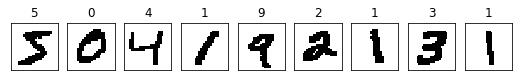

In [9]:
fig = plt.figure(figsize=(10,5))
for i in range(9):
    subplot = fig.add_subplot(4, 10, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % (y_train[i]))
    subplot.imshow(x_train[i].reshape(28,28), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')

# 2. Data preprocessing
MNIST 데이터로 학습을 할 때에, keras 혹은 tensorflow에서는 기본으로 (N,H,W,C) 형태의 4차원 tensor를 인풋으로 학습합니다. 따라서 다운로드 받은 mnist데이터를 다음과 같은 형태로 reshape 해야하는 전처리 과정이 필요합니다.

In [10]:
# input image dimensions
img_rows, img_cols = 28, 28
num_classes =10

In [11]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

아웃풋은 one-hot encoding 방식으로 표현된 벡터로 표현합니다. MNIST의 총 클래수 갯수는 10개이므로 (N,10)의 형태로 reshape하는 전처리 과정이 필요합니다.

In [12]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [13]:
print ('x_train shape:',x_train.shape)
print ('x_test shape:',x_test.shape)
print ('y_train shape:',y_train.shape)
print ('y_test shape:',y_test.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10)
y_test shape: (10000, 10)


# 실습1. Padding 과 Stride
padding과 stride를 바꿔가며 아웃풋의 형태가 어떻게 변하는지 알아보는 실습입니다.
1. padding :
padding="same" 은 padding을 사용하여 인풋과 아웃풋 형태가 동일하게 한다는 의미입니다. 반대로 padding="valid"는 padding 을 사용하지 않는다는 의미입니다.

2. stride :
stride는 (가로이동수, 세로이동수) 로 표현합니다. 주로 (1,1), (2,2) 와 같이 가로,세로 동일하게 이동합니다.

커널을 정의할 때는, 
1. 커널의 갯수
2. 커널의 사이즈
3. 스트라이드
4. 패딩 여부
가 필요합니다.

In [14]:
model = Sequential()
model.add(Conv2D(filters = 2, 
                kernel_size=(3,3),
                strides = (1,1),
                padding='same',
                input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

생성된 모델은 **summary()** 함수를 통해 그 구조를 출력할 수 있습니다.

In [15]:
print (input_shape)
print( model.summary())

(28, 28, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 2)         20        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 2)         0         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
model = Sequential()
model.add(Conv2D(filters = 2, 
                kernel_size=(3,3),
                strides = (3,3),
                padding='same',
                input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 10, 10, 2)         20        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 2)           0         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [18]:
model = Sequential()
model.add(Conv2D(filters = 2, 
                kernel_size=(3,3),
                strides = (1,1),
                padding='valid',
                input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

In [19]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 2)         20        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 2)         0         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


Now, Guess how output looks like!

In [20]:
model = Sequential()
model.add(Conv2D(filters = 3, 
                kernel_size=(5,5),
                strides = (1,1),
                padding='same',
                input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

In [21]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 3)         78        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 3)         0         
Total params: 78
Trainable params: 78
Non-trainable params: 0
_________________________________________________________________


# 2 .convolution filter의 역할
CNN에서의 filter 혹은 kernel은 이미지의 특징을 추출하기 위한 공용 파라미터를 의미합니다. 따라서 이 filter를 학습함에 따라 목표에 맞는(예를 들어, 1~10 까지 classifcation) kernel weight들을 학습하는 것이 CNN의 feature extraction 과정에서 하는 것입니다.
그렇다면 filter가 어떻게 특징을 추출할 수 있는 것일까요? 
filter에 수업 때 배운 여러 weight들을 집어넣으면서 이미지에서 어떤 feature가 추출되는지실습을 통해 알아보겠습니다.

아래 함수는, 사용한 filter와 그 filter를 통해 나온 output을 plot하는 함수입니다.

In [22]:
def plot_cnn(filter_vals, applied_vals):
    fig = plt.figure(figsize=(10,3))

    for i in range(2):
        subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(filter_vals[:,:,0,i],
                       cmap=plt.cm.gray_r, interpolation='nearest')

    v_max = np.max(applied_vals)

    for i in range(9):
        subplot = fig.add_subplot(3, 10, i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.set_title('%d' % np.argmax(y_train[i]))
        subplot.imshow(x_train[:9].T[0].T[i].reshape((28,28)), vmin=0, vmax=1,
                       cmap=plt.cm.gray_r, interpolation='nearest')

        subplot = fig.add_subplot(3, 10, 10+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(applied_vals[i,:,:,0], vmin=0, vmax=v_max,
                       cmap=plt.cm.gray_r, interpolation='nearest')

        subplot = fig.add_subplot(3, 10, 20+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(applied_vals[i,:,:,1], vmin=0, vmax=v_max,
                       cmap=plt.cm.gray_r, interpolation='nearest')

먼저, CNN에서 feature extraction 부분을 구성하는, convolution layer와 pooling layer 를 가지는 모델을 만들어보겠습니다.

In [23]:
model = Sequential()
model.add(Conv2D(filters = 2, 
                kernel_size=(3,3),
                strides = (1,1),
                padding='same',
                use_bias =False,
                input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

In [24]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 2)         18        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 2)         0         
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


모델의 구조는 정해졌으니, 이 정해진 구조에 특정한 input을 넣으면 convolution layer와 pooling layer의 output을 리턴해주는 간단한 함수입니다.

In [25]:
conv_output_func = K.function([model.input], [model.layers[0].output])
pool_output_func = K.function([model.input], [model.layers[1].output])

### (1)with initialized(randomed) weights
모델의 구조를 정하고, 커널이 initialize 되었을 때, 트레이닝 데이터 9개를 넣으면 어떤 모습일지 확인해봅니다.

In [26]:
conv_output = np.asarray(conv_output_func([x_train[0:9]]))[0]
print (conv_output.shape)

(9, 28, 28, 2)


In [27]:
conv_weights = np.asarray(model.layers[0].get_weights())[0]

In [28]:
pool_output = np.asarray(pool_output_func([x_train[0:9]]))[0]

filter(convolution)을 거치고 난 후의 output은 어떤 모습일까?

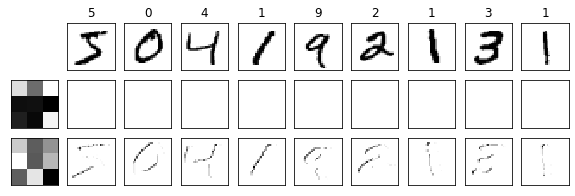

In [29]:
plot_cnn(conv_weights,conv_output)

pooling을 거치고 난 후의 output은 어떤 모습일까?

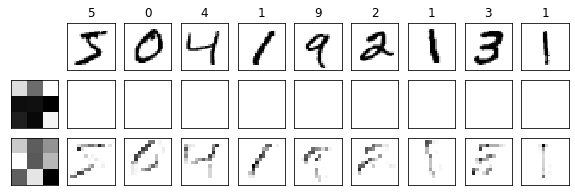

In [30]:
plot_cnn(conv_weights,pool_output)

### <font color=red> (2) TRY! create own weights and see what happens!</font>

**Kernel for detecting several patterns**
아래있는 여러 kernel들을 참고하여 2가지의 filter을 고른 후, 모델에 해당filter를 적용해주세요
예시)

<img src="./images/convolutional_kernel.png" alt="convolutional_kernel" title="convolutional_kernel" />


In [31]:
blur_filter = np.array(
    [[0.0625,0.125,0.0625],
     [0.125,0.25,0.125],
     [0.0625,0.125,0.0625]]) 
edge_filter = np.array(
[[-1,-1,-1],
 [-1,8,-1],
 [-1,-1,-1]]) 

filter_array = np.zeros([3,3,1,2])
filter_array[:,:,0,0] = blur_filter
filter_array[:,:,0,1] = edge_filter

In [32]:
model.layers[0].set_weights(filter_array.reshape(1,3,3,1,2))

In [33]:
conv_output = np.asarray(conv_output_func([x_train[0:9]]))[0]
print (conv_output.shape)

(9, 28, 28, 2)


In [34]:
conv_weights = np.asarray(model.layers[0].get_weights())[0]

In [35]:
pool_output = np.asarray(pool_output_func([x_train[0:9]]))[0]

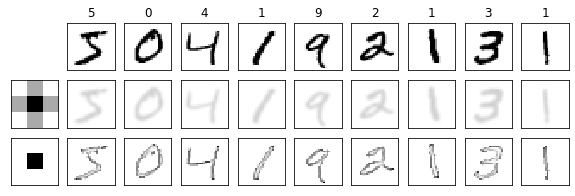

In [36]:
plot_cnn(conv_weights,conv_output)

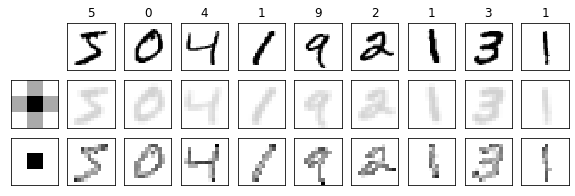

In [37]:
plot_cnn(conv_weights,pool_output)

위의 실험에서 보았듯이, 어떠한 kernel을 사용하냐에 따라 추출되는 feature가 다릅니다. 이 feature들은 마지막에 클래지피게이션하는 input으로 사용되므로 목적에 맞는 feature를 잘 추출하는 것이 필요합니다. 따라서 CNN에서는 이 kernel를 학습합니다. 

# 2. MLP vs CNN
지금까지 CNN의 feature extractor 부분에 집중하여 1. convolution layer의 필터갯수, 필터크기, 스트라이드, 패딩여부에 따라 output 형태가 달라지고,
2. kernel 에 따라 다양한 feature가 추출되므로, 이 kernel를 학습하는 것이 중요하다는 것을 알게되었습니다.

다음으로는 MLP와 CNN를 각각 학습하면서, MLP와 CNN를 비교해보겠습니다.

<img src="./images/mlp_structure.png" alt="mlp_structure" title="mlp_structure" />

In [38]:
def plot_prediction(model, input_data, correctness):
    predicted_result = model.predict(input_data)
    predicted_labels = np.argmax(predicted_result, axis=1)

    test_labels = np.argmax(y_test, axis=1)
    result = []
    if correctness ==False:
        for n in range(0, len(test_labels)):
            if predicted_labels[n] != test_labels[n]:
                result.append(n)
        title = "wrong"
    elif correctness ==True:
        for n in range(0, len(test_labels)):
            if predicted_labels[n] == test_labels[n]:
                result.append(n)
        title="correct"
    
    samples = random.choices(population=result, k=16)

    count = 0
    nrows = ncols = 4

    plt.figure(figsize=(12,8))

    for n in samples:
        count += 1
        plt.subplot(nrows, ncols, count)
        if correctness ==False:
            plt.imshow(x_test[n].reshape(28, 28), cmap='Reds', interpolation='nearest')
        elif correctness ==True:
            plt.imshow(x_test[n].reshape(28, 28), cmap='Blues', interpolation='nearest')
        tmp = "Label:" + str(test_labels[n]) + ", Prediction:" + str(predicted_labels[n])
        plt.title(tmp)

    plt.tight_layout()
    plt.suptitle(str(title)+' prediction', fontsize=15)
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    return samples

In [39]:
import os

In [40]:
batch_size= 128

## (1) Building MLP model

In [41]:
from keras.callbacks import ModelCheckpoint

In [42]:
MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

mlp_model_path = MODEL_SAVE_FOLDER_PATH + 'mlp_model.hdf5'

In [43]:
def mlp_model_build(input_shape, num_classes):
    model = Sequential()
    
    model.add(Dense(300, input_shape = input_shape, kernel_initializer='he_normal'))     # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(100, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(10, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('softmax'))

    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    cb_checkpoint = ModelCheckpoint(filepath=mlp_model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)

    return model,cb_checkpoint

In [44]:
mlp_model,cb_checkpoint = mlp_model_build(input_shape= (28*28,), num_classes=num_classes)
mlp_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
activation_1 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
activation_3 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [45]:
mlp_history = mlp_model.fit(x_train.reshape(60000,28*28), 
                            y_train, 
                            validation_split = 0.3,
                            callbacks=[cb_checkpoint],
                            batch_size=batch_size,
                            epochs = 20, 
                            verbose = 1)

Train on 42000 samples, validate on 18000 samples
Epoch 1/20
42000/42000 [==============================] - 1s 35us/step - loss: 0.3148 - accuracy: 0.9055 - val_loss: 0.2011 - val_accuracy: 0.9381

Epoch 00001: val_loss improved from inf to 0.20112, saving model to ./model/mlp_model.hdf5
Epoch 2/20
42000/42000 [==============================] - 1s 24us/step - loss: 0.1190 - accuracy: 0.9647 - val_loss: 0.1772 - val_accuracy: 0.9467

Epoch 00002: val_loss improved from 0.20112 to 0.17723, saving model to ./model/mlp_model.hdf5
Epoch 3/20
42000/42000 [==============================] - 1s 26us/step - loss: 0.0773 - accuracy: 0.9762 - val_loss: 0.1172 - val_accuracy: 0.9651

Epoch 00003: val_loss improved from 0.17723 to 0.11718, saving model to ./model/mlp_model.hdf5
Epoch 4/20
42000/42000 [==============================] - 1s 25us/step - loss: 0.0543 - accuracy: 0.9835 - val_loss: 0.1040 - val_accuracy: 0.9722

Epoch 00004: val_loss improved from 0.11718 to 0.10398, saving model to ./mod

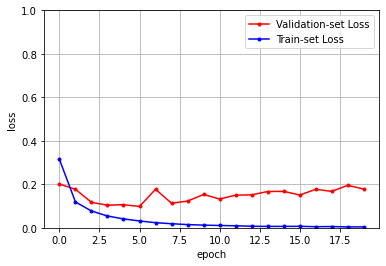

In [46]:
mlp_vloss= mlp_history.history['val_loss']
mlp_loss = mlp_history.history['loss']

x_len = np.arange(len(mlp_loss))
plt.plot(x_len, mlp_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, mlp_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0,1)
plt.show()

In [47]:
mlp_model.load_weights(mlp_model_path)

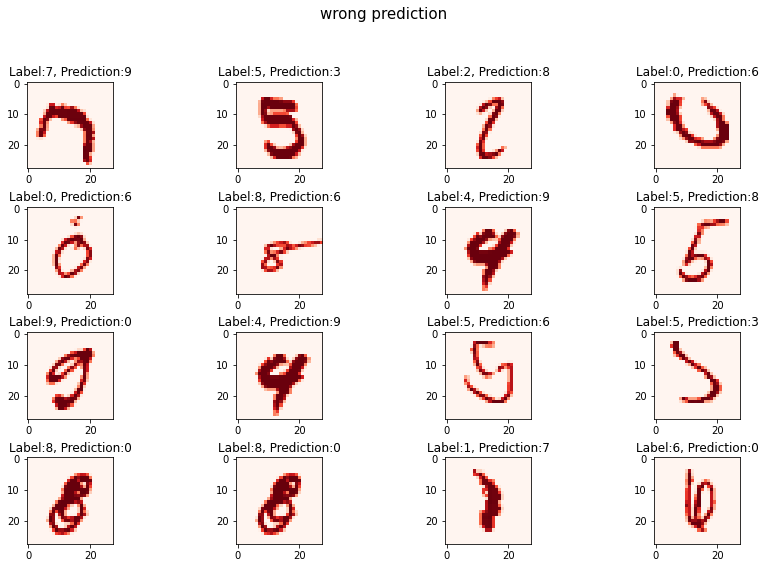

In [48]:
wrong_samples_idx = plot_prediction(model =mlp_model, input_data = x_test.reshape(10000,28*28,),correctness =False)

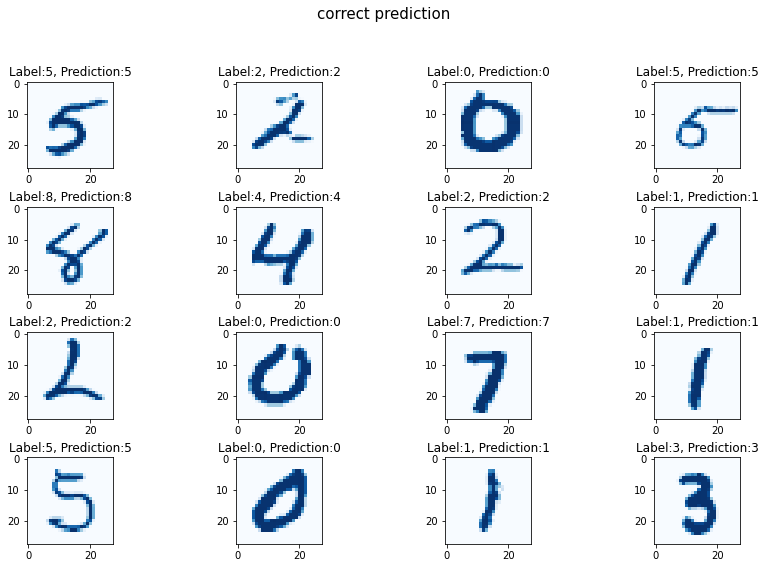

In [49]:
correct_samples_idx = plot_prediction(model =mlp_model, input_data = x_test.reshape(10000,28*28,),correctness =True)

## data를 translation 했을때

<img src="./images/image_translation.jpg" alt="image_translation" title="image_translation" />

In [50]:
translation_matrix = np.float32([ [1,0,0], [0,1,-3] ])
x_test_translation=np.asarray([cv2.warpAffine(x, translation_matrix, (28, 28)) for x in x_test[correct_samples_idx]])

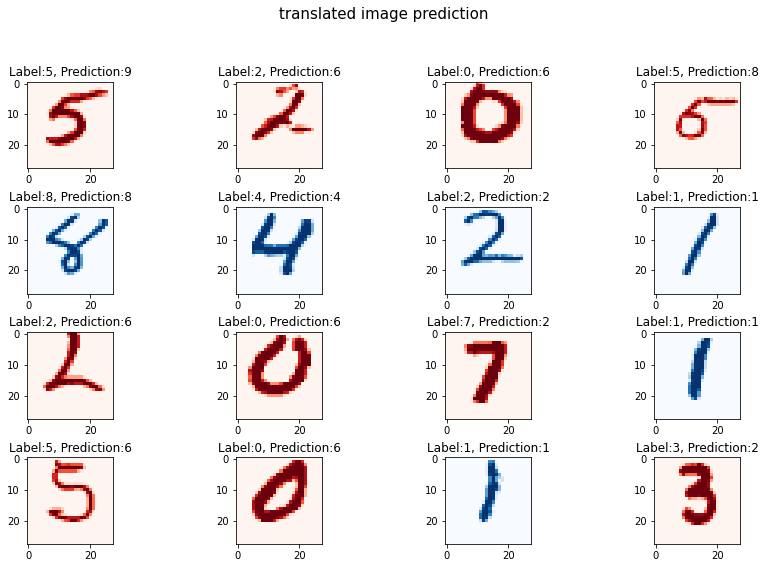

In [51]:
predicted_result = mlp_model.predict(x_test_translation.reshape(16,28*28))
predicted_labels = np.argmax(predicted_result, axis=1)

test_labels = np.argmax(y_test[correct_samples_idx], axis=1)
result = []


count = 0
nrows = ncols = 4

plt.figure(figsize=(12,8))

for n in range(0,16):
    count += 1
    #if test_labels[n]!=predicted_labels[n]:
    plt.subplot(nrows, ncols, count)
    if test_labels[n]!=predicted_labels[n]:
        plt.imshow(x_test_translation[n].reshape(28, 28), cmap='Reds', interpolation='nearest')
    else : 
        plt.imshow(x_test_translation[n].reshape(28, 28), cmap='Blues', interpolation='nearest')
    
    tmp = "Label:" + str(test_labels[n]) + ", Prediction:" + str(predicted_labels[n])
    plt.title(tmp)

plt.tight_layout()
plt.suptitle('translated image prediction', fontsize=15)
plt.subplots_adjust(top=0.85)
plt.show()

<img src="./images/image_rotation1.png" alt="image_rotation1" title="image_rotation1" />
<img src="./images/image_rotation2.png" alt="image_rotation2" title="image_rotation2" />

In [52]:
rotation_matrix= cv2.getRotationMatrix2D((28/2, 28/2), 10, 1.0)
x_test_rotation=np.asarray([cv2.warpAffine(x, rotation_matrix, (28, 28)) for x in x_test[correct_samples_idx]])

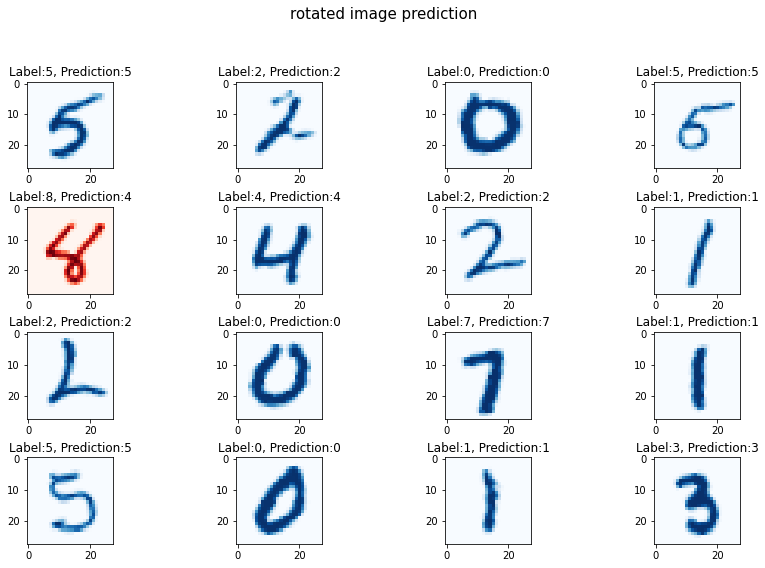

In [53]:
predicted_result = mlp_model.predict(x_test_rotation.reshape(16,28*28))
predicted_labels = np.argmax(predicted_result, axis=1)

test_labels = np.argmax(y_test[correct_samples_idx], axis=1)
result = []


count = 0
nrows = ncols = 4

plt.figure(figsize=(12,8))

for n in range(0,16):
    count += 1
    #if test_labels[n]!=predicted_labels[n]:
    plt.subplot(nrows, ncols, count)
    if test_labels[n]!=predicted_labels[n]:
        plt.imshow(x_test_rotation[n].reshape(28, 28), cmap='Reds', interpolation='nearest')
    else : 
        plt.imshow(x_test_rotation[n].reshape(28, 28), cmap='Blues', interpolation='nearest')
    
    tmp = "Label:" + str(test_labels[n]) + ", Prediction:" + str(predicted_labels[n])
    plt.title(tmp)

plt.tight_layout()
plt.suptitle('rotated image prediction', fontsize=15)
plt.subplots_adjust(top=0.85)
plt.show()

## (2) Build CNN model

In [54]:
MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

cnn_model_path = MODEL_SAVE_FOLDER_PATH + 'cnn_model.hdf5'

CNN은 MLP와는 달리 이미지를 그대로 받아 오기 때문에, 
인풋은 [batch, 이미지높이, 이미지너비, 이미지채널]의 모양을 가지는 4차원 텐서이며,
Y는 분류의 사용될 라벨 값을 받아오는 [batch]의 모양의 1차원 텐서입니다.

In [55]:
def cnn_model_build(input_shape, num_classes):
        model = Sequential()
        # CONV => RELU => POOL
        model.add(Conv2D(2, kernel_size=(3,3), padding="same",input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # CONV => RELU => POOL
        model.add(Conv2D(10, kernel_size=(5,5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # CONV => RELU => POOL
        model.add(Conv2D(50, kernel_size=(7,7), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # Flatten => RELU layers
        model.add(Flatten())
        model.add(Dense(50))
        model.add(Activation("relu"))
 
        # a softmax classifier
        model.add(Dense(num_classes))
        model.add(Activation("softmax"))
        cb_checkpoint = ModelCheckpoint(filepath=cnn_model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)
        model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
        return model,cb_checkpoint


In [56]:
cnn_model,cb_checkpoint = cnn_model_build(input_shape = (28,28,1), num_classes=num_classes)
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 2)         20        
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 2)         0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 2)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 10)        510       
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 10)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 10)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 50)         

In [57]:
cnn_history = cnn_model.fit(x_train, 
                            y_train, 
                            validation_split = 0.3, 
                            callbacks=[cb_checkpoint],
                            batch_size=batch_size,
                            epochs = 20, 
                            verbose = 1)

Train on 42000 samples, validate on 18000 samples
Epoch 1/20
42000/42000 [==============================] - 3s 64us/step - loss: 0.4529 - accuracy: 0.8607 - val_loss: 0.4597 - val_accuracy: 0.8522

Epoch 00001: val_loss improved from inf to 0.45967, saving model to ./model/cnn_model.hdf5
Epoch 2/20
42000/42000 [==============================] - 3s 64us/step - loss: 0.1219 - accuracy: 0.9629 - val_loss: 0.1275 - val_accuracy: 0.9581

Epoch 00002: val_loss improved from 0.45967 to 0.12747, saving model to ./model/cnn_model.hdf5
Epoch 3/20
42000/42000 [==============================] - 3s 69us/step - loss: 0.0798 - accuracy: 0.9755 - val_loss: 0.0824 - val_accuracy: 0.9740

Epoch 00003: val_loss improved from 0.12747 to 0.08242, saving model to ./model/cnn_model.hdf5
Epoch 4/20
42000/42000 [==============================] - 3s 63us/step - loss: 0.0615 - accuracy: 0.9799 - val_loss: 0.0711 - val_accuracy: 0.9790

Epoch 00004: val_loss improved from 0.08242 to 0.07113, saving model to ./mod

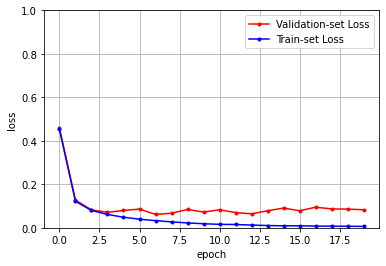

In [58]:
cnn_vloss= cnn_history.history['val_loss']
cnn_loss = cnn_history.history['loss']

x_len = np.arange(len(cnn_loss))
plt.plot(x_len, cnn_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, cnn_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0,1)
plt.show()

In [59]:
cnn_model.load_weights(cnn_model_path)

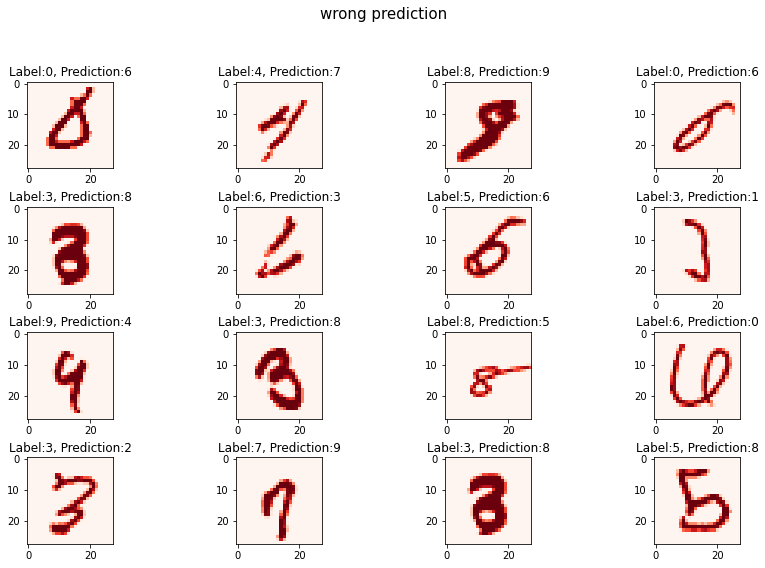

In [60]:
wrong_samples_idx = plot_prediction(model =cnn_model, input_data = x_test.reshape(10000,28,28,1),correctness =False)

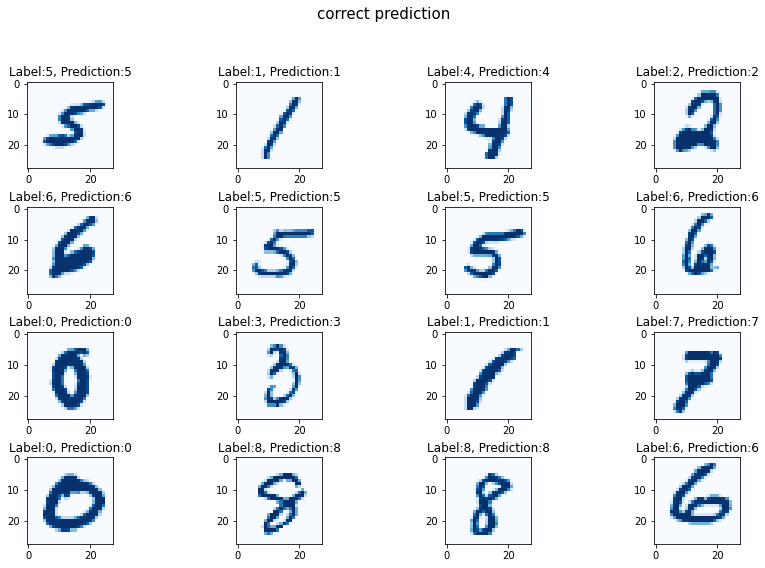

In [61]:
correct_samples_idx = plot_prediction(model =cnn_model, input_data = x_test.reshape(10000,28,28,1),correctness =True)

In [62]:
x_test_translation=np.asarray([cv2.warpAffine(x, translation_matrix, (28, 28)) for x in x_test[correct_samples_idx]])

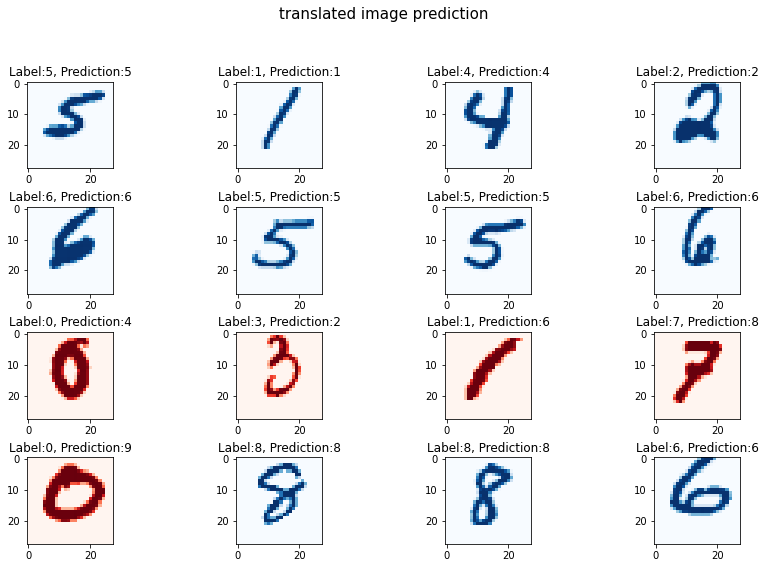

In [63]:
predicted_result = cnn_model.predict(x_test_translation.reshape(16,28,28,1))
predicted_labels = np.argmax(predicted_result, axis=1)

test_labels = np.argmax(y_test[correct_samples_idx], axis=1)
result = []


count = 0
nrows = ncols = 4

plt.figure(figsize=(12,8))

for n in range(0,16):
    count += 1
    plt.subplot(nrows, ncols, count)
    if test_labels[n]!=predicted_labels[n]:
        plt.imshow(x_test_translation[n].reshape(28, 28), cmap='Reds', interpolation='nearest')
    else : 
        plt.imshow(x_test_translation[n].reshape(28, 28), cmap='Blues', interpolation='nearest')
    tmp = "Label:" + str(test_labels[n]) + ", Prediction:" + str(predicted_labels[n])
    plt.title(tmp)

plt.tight_layout()
plt.suptitle('translated image prediction', fontsize=15)
plt.subplots_adjust(top=0.85)
plt.show()

In [64]:
x_test_rotation=np.asarray([cv2.warpAffine(x, rotation_matrix, (28, 28)) for x in x_test[correct_samples_idx]])

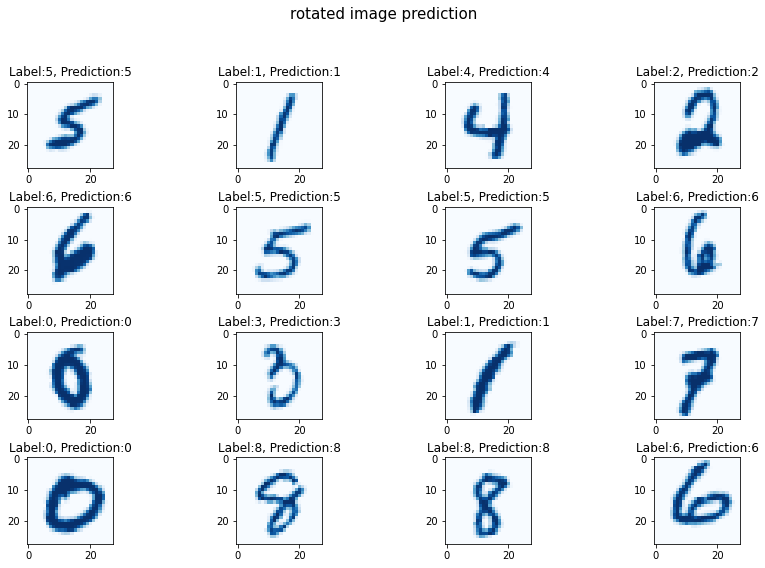

In [65]:
predicted_result = cnn_model.predict(x_test_rotation.reshape(16,28,28,1))
predicted_labels = np.argmax(predicted_result, axis=1)

test_labels = np.argmax(y_test[correct_samples_idx], axis=1)
result = []


count = 0
nrows = ncols = 4

plt.figure(figsize=(12,8))

for n in range(0,16):
    count += 1
    plt.subplot(nrows, ncols, count)
    if test_labels[n]!=predicted_labels[n]:
        plt.imshow(x_test_rotation[n].reshape(28, 28), cmap='Reds', interpolation='nearest')
    else : 
        plt.imshow(x_test_rotation[n].reshape(28, 28), cmap='Blues', interpolation='nearest')
    tmp = "Label:" + str(test_labels[n]) + ", Prediction:" + str(predicted_labels[n])
    plt.title(tmp)

plt.tight_layout()
plt.suptitle('rotated image prediction', fontsize=15)
plt.subplots_adjust(top=0.85)
plt.show()